# TODO:

3. Run the experiments
5. Add more models
5. Report
6. Presentation

# Imports and consts

In [ ]:
IS_IN_COLAB=False

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import cv2
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, Reshape, Dropout
from keras.optimizers import Adam, SGD, Lion
from keras.regularizers import L2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import shutil
import random
import pickle
import pandas as pd
from enum import Enum


In [ ]:
if IS_IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  !7z x /content/drive/'My Drive'/Studia/Masters/DeepLearning/Project2/Dataset/train.7z -o/content/dataset/


Mounted at /content/drive

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/Studia/Masters/DeepLearning/Project2/Dataset/                                                                               1 file, 1121103842 bytes (1070 MiB)

Extracting archive: /content/drive/My Drive/Studia/Masters/DeepLearning/Project2/Dataset/train.7z
--
Path = /content/drive/My Drive/Studia/Masters/DeepLearning/Project2/Dataset/train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 38 - train/audio/_background_noise_/doing_the_dishes.wav

In [ ]:
# !7z x /content/drive/'My Drive'/Studia/Masters/DeepLearning/Project2/Dataset/test.7z -o/content/dataset/

In [ ]:
if IS_IN_COLAB:
  DATASET_DIR = '/content/dataset/train/audio/'
else:
  DATASET_DIR = '../Dataset/train/audio/'
# DATASET_DIR_TEST = '/content/dataset/test/audio/'

# Helper Functions

In [ ]:
def set_seed(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [ ]:
def preprocess_data(row, num_classes):
    signal_path = DATASET_DIR + row['label_name'] + '/' + row['path']
    samples, sample_rate = librosa.load(signal_path, mono=True, sr=None)
    freqs, times, spectrogram = log_specgram(samples, sample_rate)
    img = cv2.resize(spectrogram, (32, 32))
    img = np.divide((img - np.mean(img)),np.std(img),out=img, where=np.std(img)!=0)
    img = np.stack((img,) * 3, axis=-1).astype(np.float32)
    label = np.zeros(num_classes)
    label[row['label']] = 1
    return img, label

def create_dataset(df, num_classes, batch_size):
    def generator():
        for index, row in df.iterrows():
            img, label = preprocess_data(row, num_classes)
            yield img, label

    dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32), tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)))
    # dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    # dataset = dataset.prefetch(2)
    return dataset

# Prepare data

In [ ]:
# This block of code was insipired by the following link:
# https://github.com/OldBonhart/TensorFlow_Speech_Recognition_Challenge/blob/master/Train___EfficientNet.ipynb
labels = os.listdir(DATASET_DIR)
data_map = {}
for ind, label in enumerate(labels):
    data_path = DATASET_DIR + label
    data_map[data_path] = label, os.listdir(data_path), ind
data_map.keys()
data_map = {}
for ind, label in enumerate(labels):
    data_path = DATASET_DIR + label
    data_map[ind] = label, os.listdir(data_path), ind

df = pd.DataFrame(data_map.values(),
                  columns=["label_name", "path", "label"])
df = df.set_index(['label_name', 'label'])
df.reset_index(inplace=True)
# background = df[df['label_name'] == '_background_noise_']
df = df[df['label_name'] != '_background_noise_']
element_to_remove = "_background_noise_"
if element_to_remove in labels:
    labels.remove(element_to_remove)


rows = []
_ = df.apply(lambda row: [rows.append([row['label_name'], row['label'], nn])
                         for nn in row.path], axis=1)
df_new = pd.DataFrame(rows, columns=df.columns)
df_new.to_csv(r'speech_commands_dataset_all_labels.csv', index=True)


df_new['label']=df_new['label'].apply(lambda x: x if x<12 else x-1)

In [ ]:
data = df_new

In [ ]:
input_shape = (32, 32, 3)
num_classes = len(labels)

# LSTM Test

In [ ]:
epochs = 10
batch_size = 128
learning_rate=0.001

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Reshape((-1, 128)),
    LSTM(128),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [ ]:
train_df, val_df = train_test_split(data, stratify=data['label'], test_size=0.1)
train_df, test_df = train_test_split(train_df, stratify=train_df['label'], test_size=0.1)
print(train_df.shape, val_df.shape)
print(train_df.dtypes)
print(train_df.head())

(52423, 3) (6473, 3)
label_name    object
label          int64
path          object
dtype: object
      label_name  label                   path
53437        yes     24  060cd039_nohash_0.wav
33047         up     15  77f185d3_nohash_0.wav
268           go      0  fb24c826_nohash_0.wav
38280         no     17  2796ac50_nohash_1.wav
30334       stop     14  28ce0c58_nohash_2.wav


In [ ]:
train_dataset = create_dataset(train_df, num_classes, batch_size)
val_dataset = create_dataset(val_df, num_classes, batch_size)


In [ ]:
model.fit(train_dataset, epochs=epochs, batch_size=batch_size, validation_data=val_dataset)

Epoch 1/10
410/410 [==============================] - 90s 212ms/step - loss: 1.6530 - accuracy: 0.5170 - val_loss: 0.9272 - val_accuracy: 0.7218
Epoch 2/10
410/410 [==============================] - 86s 211ms/step - loss: 0.7235 - accuracy: 0.7842 - val_loss: 0.6406 - val_accuracy: 0.8083
Epoch 3/10
410/410 [==============================] - 86s 210ms/step - loss: 0.5406 - accuracy: 0.8391 - val_loss: 0.5069 - val_accuracy: 0.8488
Epoch 4/10
410/410 [==============================] - 90s 219ms/step - loss: 0.4432 - accuracy: 0.8662 - val_loss: 0.4891 - val_accuracy: 0.8539
Epoch 5/10
410/410 [==============================] - 89s 217ms/step - loss: 0.3768 - accuracy: 0.8853 - val_loss: 0.5060 - val_accuracy: 0.8489
Epoch 6/10
410/410 [==============================] - 85s 208ms/step - loss: 0.3225 - accuracy: 0.9019 - val_loss: 0.5087 - val_accuracy: 0.8505
Epoch 7/10
410/410 [==============================] - 84s 205ms/step - loss: 0.2835 - accuracy: 0.9137 - val_loss: 0.4623 - val_ac

In [ ]:
test_data=create_dataset(test_df, num_classes, batch_size)

In [ ]:
result=model.predict(test_data)

46/46 [==============================] - 9s 184ms/step


In [ ]:
y_pred=np.argmax(result,axis=1)

In [ ]:
y_true = []
for index, row in test_df.iterrows():
    y_true.append(row['label'])

In [ ]:
correct=0
for i,y in enumerate(y_pred):
    if y==y_true[i]:
      correct+=1
correct/len(y_true)

0.8571673819742489

Accuracy: 0.8571673819742489


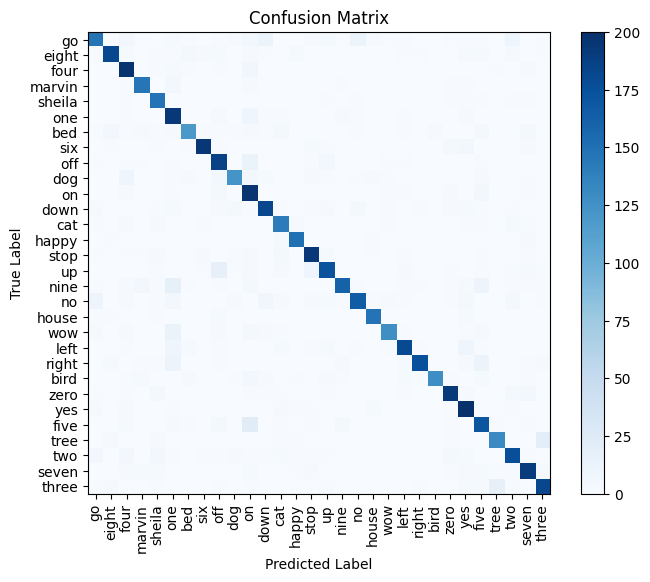

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Set tick labels
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.yticks(np.arange(len(labels)), labels, rotation=0)
plt.show()

# Experiments Pipeline


## Functions and classes

In [ ]:
class AugmentationTechnique(Enum):
    NoAugmentation = 0
    Tempo = 1
    Echo = 2
    Noise = 3

class ModelType(Enum):
    LSTM =1
    Transformer = 2

class OptimizerType(Enum):
    Adam = 1
    Sgd=2
    Lion=3
class RegularizationType(Enum):
    NoRegularization = 1
    L2 =2
    Dropout=3
def getRegularizer(regularizerType,value):
    match regularizerType:
        case RegularizationType.L2:
            return L2(value)
def getDenseLayer(model,regularization, activation,nodes):
        match regularization['type']:
            case RegularizationType.Dropout:
                model.add(Dropout(rate=regularization['value']))
                model.add(Dense(nodes, activation=activation))
            case RegularizationType.NoRegularization:
                model.add(Dense(nodes, activation=activation))
            case RegularizationType.L2:
                model.add(Dense(nodes, activation=activation, kernel_regularizer=getRegularizer(regularizerType=regularization['type'],value=regularization['value'])))
def getAugmentationLayer(model,technique, seed):
    match technique:
        case AugmentationTechnique.NoAugmentation:
            return;


class Model:
    def fit(self,batch_size,epochs,train_images,train_labels,valid_images,valid_labels):
        pass
    def predict(self,test_images):
        pass
    def __init__(self,optimizer,loss,metrics):
        pass

class CustomLSTM(Model):
    def __init__(self,optimizer,loss,metrics,regularizer,seed,augmentation,num_classes):
        self.model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Reshape((-1, 128)),
            LSTM(128),
            Dense(num_classes, activation='softmax')
        ])
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self,batch_size,epochs,train_dataset,val_dataset):
        return self.model.fit(train_dataset, epochs=epochs, batch_size=batch_size, validation_data=val_dataset)

    def predict(self,test_df):
        result=self.model.predict(test_df)
        return np.argmax(result,axis=1)




In [ ]:
def createModel(modelType, optimizer, loss, metrics, regularizer,seed,augmentation,num_classes)->Model:
    match modelType:
        case ModelType.LSTM:
            return CustomLSTM(optimizer=optimizer,loss=loss,metrics=metrics,regularizer=regularizer,seed=seed,augmentation=augmentation,num_classes=num_classes)



def getOptimizer(optimizer_type, learningRate):
    match optimizer_type:
        case OptimizerType.Adam:
            return Adam(learning_rate=learningRate)
        case OptimizerType.Sgd:
            return SGD(learning_rate=learningRate)
        case OptimizerType.Lion:
            return Lion(learning_rate=learningRate)

In [ ]:
def create_dataset_lstm(df, num_classes, batch_size):
    def generator():
        for index, row in df.iterrows():
            img, label = preprocess_data(row, num_classes)
            yield img, label

    dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32), tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)))
    # dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    # dataset = dataset.prefetch(2)
    return dataset

def getDatasetGenerator(modelType,df,num_classes,batch_size):
    match(modelType):
        case ModelType.LSTM:
            return create_dataset_lstm(df,num_classes,batch_size)


In [ ]:
def performSingleExperiment(modelType, batchSize, epochNumber, augmentation, learningRate, seed, optimizerType,num_classes,train_data,val_data,test_split_dataset,split):
    # print(f"Performing experiment with model: {modelType}, batch size: {batchSize}, epochs: {epochNumber}, augmentation: {augmentation}, regularizer: {regularizer}, learning rate: {learningRate}, seed: {seed}")
    print(f"Performing experiment with model: {modelType}, batch size: {batchSize}, epochs: {epochNumber}, augmentation: {augmentation}, regularization: {RegularizationType.NoRegularization.name},learning rate: {learningRate}, seed: {seed}, optimizer: {optimizerType.name}")
    set_seed(seed)
    # TODO: Increase the size of used dataset to 10% or even 20%
    train_dataset = getDatasetGenerator(modelType,train_data.head(int(len(train_data)/20)), num_classes, batchSize)
    val_dataset = getDatasetGenerator(modelType,val_data.head(int(len(val_data)/20)), num_classes, batchSize)
    model = createModel(num_classes=num_classes,modelType=modelType,regularizer={"type":RegularizationType.NoRegularization,"value":0},optimizer=getOptimizer(optimizer_type=optimizerType,learningRate=learningRate), loss='categorical_crossentropy', metrics=['accuracy'],seed=seed, augmentation=augmentation)
    # train the model
    history = model.fit(batch_size=batchSize,epochs=epochNumber, train_dataset=train_dataset,val_dataset=val_dataset)

    # get accuracy
    test_split_dataset_generator = getDatasetGenerator(modelType,test_split_dataset, num_classes, batchSize)
    y_pred = model.predict(test_split_dataset_generator)
    y_true = []
    for index, row in test_split_dataset.iterrows():
        y_true.append(row['label'])

    accuracy = accuracy_score(y_true, y_pred)
    # TODO: Update this, make sure it can be easily transformed to a dataframe, also add all parameters
    return [accuracy, augmentation,optimizerType,batchSize,learningRate,epochNumber, seed,split], history


def performExperiment(batchSizes, learningRates, numberOfEpochs, augmentationTechniques, regularizers,modelType,seeds,optimizers,num_classes, trainData, splits):
    results = []
    histories = []
    accuracy=0
    accuracyMean = 0
    accuracyArray=[]
    train_split_dataset, val_split_dataset = train_test_split(trainData, stratify=trainData['label'], test_size=0.1)
    train_split_dataset, test_split_dataset = train_test_split(train_split_dataset, stratify=train_split_dataset['label'], test_size=splits[0])

    currentBestBatchSize = batchSizes[0]
    currentBestLearningRate = learningRates[0]
    currentBestNumberOfEpochs = 10
    lastExperimentNumberOfEpochs = 50
    currentBestAugmentation =augmentationTechniques[0]
    currentBestOptimizer = optimizers[0]
    currentBestSplit = splits[0]

    for seed in seeds:
        result,history=performSingleExperiment(split=currentBestSplit,test_split_dataset=test_split_dataset,train_data=train_split_dataset,val_data=val_split_dataset,num_classes=num_classes,modelType=modelType,learningRate=currentBestLearningRate,batchSize=currentBestBatchSize,epochNumber=currentBestNumberOfEpochs,augmentation=currentBestAugmentation,seed=seed,optimizerType=currentBestOptimizer)
        results.append(result)
        accuracyArray.append(result[0])
    accuracyMean=np.mean(accuracyArray)
    accuracyArray=[]


    for augmentation in augmentationTechniques[1:]:
        for seed in seeds:
            result,history=performSingleExperiment(split=currentBestSplit,test_split_dataset=test_split_dataset,train_data=train_split_dataset,val_data=val_split_dataset,num_classes=num_classes,modelType=modelType,learningRate=currentBestLearningRate,batchSize=currentBestBatchSize,epochNumber=currentBestNumberOfEpochs,augmentation=augmentation,seed=seed,optimizerType=currentBestOptimizer)
            results.append(result)
            accuracyArray.append(result[0])
        if np.mean(accuracyArray)>accuracyMean:
            currentBestAugmentation=augmentation
            accuracyMean=np.mean(accuracyArray)

        accuracyArray=[]




    for optimizer in optimizers[1:]:
        for learningRate in learningRates[1:]:
            for seed in seeds:
                result,history=performSingleExperiment(split=currentBestSplit,test_split_dataset=test_split_dataset,train_data=train_split_dataset,val_data=val_split_dataset,num_classes=num_classes,modelType=modelType,learningRate=currentBestLearningRate,batchSize=currentBestBatchSize,epochNumber=currentBestNumberOfEpochs,augmentation=currentBestAugmentation,seed=seed,optimizerType=optimizer)
                results.append(result)
                accuracyArray.append(result[0])
            if np.mean(accuracyArray)>accuracyMean:
                currentBestLearningRate=learningRate
                currentBestOptimizer=optimizer
                accuracyMean=np.mean(accuracyArray)

        accuracyArray=[]


    for batchSize in batchSizes[1:]:
        for seed in seeds:
            result,history=performSingleExperiment(split=currentBestSplit,test_split_dataset=test_split_dataset,train_data=train_split_dataset,val_data=val_split_dataset,num_classes=num_classes,modelType=modelType,learningRate=currentBestLearningRate,batchSize=batchSize,epochNumber=currentBestNumberOfEpochs,augmentation=currentBestAugmentation,seed=seed,optimizerType=currentBestOptimizer)
            results.append(result)
            accuracyArray.append(result[0])
        if np.mean(accuracyArray)>accuracyMean:
            currentBestBatchSize=batchSize
            accuracyMean=np.mean(accuracyArray)

        accuracyArray=[]


    for split in splits[1:]:
        for seed in seeds:
            set_seed(seed)
            train_split_dataset, val_split_dataset = train_test_split(trainData, stratify=trainData['label'], test_size=0.1)
            train_split_dataset, test_split_dataset = train_test_split(train_split_dataset, stratify=train_split_dataset['label'], test_size=split)

            result,history=performSingleExperiment(split=split,test_split_dataset=test_split_dataset,train_data=train_split_dataset,val_data=val_split_dataset,num_classes=num_classes,modelType=modelType,learningRate=currentBestLearningRate,batchSize=currentBestBatchSize,epochNumber=currentBestNumberOfEpochs,augmentation=augmentation,seed=seed,optimizerType=currentBestOptimizer)
            results.append(result)
            accuracyArray.append(result[0])
        if np.mean(accuracyArray)>accuracyMean:
            currentBestSplit=split
            accuracyMean=np.mean(accuracyArray)

        accuracyArray=[]

    result,history=performSingleExperiment(split=currentBestSplit,test_split_dataset=test_split_dataset,train_data=train_split_dataset,val_data=val_split_dataset,num_classes=num_classes,modelType=modelType,learningRate=currentBestLearningRate,batchSize=currentBestBatchSize,epochNumber=lastExperimentNumberOfEpochs,augmentation=currentBestAugmentation,seed=seed,optimizerType=currentBestOptimizer)
    accuracy = result[0]
    results.append(result)
    histories.append(history)



    return results, [accuracy,currentBestBatchSize, currentBestLearningRate,currentBestNumberOfEpochs, currentBestAugmentation,currentBestOptimizer,currentBestSplit], histories

In [ ]:
def performExperimentsOnModel(modelType):
    results, best, histories = performExperiment(modelType=ModelType.LSTM,batchSizes=batchSizes,learningRates=learningRates,numberOfEpochs=numberOfEpochs,augmentationTechniques=augmentationTechniques,regularizers=regularizers,seeds=seeds, optimizers=optimizers,num_classes=num_classes, splits=splits, trainData=data)
    print(results)
    print(best)
    print(histories)
    with open("results-"+str(modelType.name),"wb") as my_csv:
        pickle.dump(results,my_csv)
    with open("best-"+str(modelType.name),"wb") as my_csv:
        pickle.dump(best,my_csv)
    with open("histories-"+str(modelType.name),"wb") as my_csv:
        pickle.dump(histories,my_csv)
    if IS_IN_COLAB:
      shutil.copy("/content/results-"+str(modelType.name), "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
      shutil.copy("/content/best-"+str(modelType.name), "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
      shutil.copy("/content/histories-"+str(modelType.name), "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    return results, best, histories

## Parameters

In [ ]:
# training process
#batchSizes =[128,64,32]
batchSizes = [64]
#learningRates = [0.01,0.005,0.001]
learningRates=[0.001]
#numberOfEpochs =[5,10,15]
numberOfEpochs=[10]

# regularization
#regularizers = [{"type":RegularizationType.NoRegularization,"value":0},{"type":RegularizationType.Dropout,"value":0.5},{"type":RegularizationType.L2,"value":0.01}]
#regularizers=[{"type":RegularizationType.NoRegularization,"value":0},{"type":RegularizationType.Dropout,"value":0.3},{"type":RegularizationType.Dropout,"value":0.5},{"type":RegularizationType.Dropout,"value":0.8},{"type":RegularizationType.L2,"value":0.001},{"type":RegularizationType.L2,"value":0.01},{"type":RegularizationType.L2,"value":0.1}]
regularizers = []
#seeds = [123,42,9]
#splits = [0.1, 0.2, 0.3]
seeds=[42]
splits=[0.1]
models = [ModelType.LSTM]

#optimizers = [OptimizerType.Adam, OptimizerType.Sgd, OptimizerType.Lion]
optimizers=[OptimizerType.Adam]
# augmentation
augmentationTechniques =[AugmentationTechnique.NoAugmentation]
#augmentationTechniques=[AugmentationTechnique.Flipping]

## Process

In [ ]:
results, best, histories =performExperimentsOnModel(ModelType.LSTM)

Performing experiment with model: ModelType.LSTM, batch size: 64, epochs: 10, augmentation: AugmentationTechnique.NoAugmentation, regularization: NoRegularization,learning rate: 0.001, seed: 42, optimizer: Adam
Epoch 1/10
41/41 [==============================] - 8s 127ms/step - loss: 3.3249 - accuracy: 0.0702 - val_loss: 3.1373 - val_accuracy: 0.0929
Epoch 2/10
41/41 [==============================] - 5s 116ms/step - loss: 2.9366 - accuracy: 0.1473 - val_loss: 2.7011 - val_accuracy: 0.2198
Epoch 3/10
41/41 [==============================] - 5s 114ms/step - loss: 2.4711 - accuracy: 0.2743 - val_loss: 2.3357 - val_accuracy: 0.3127
Epoch 4/10
41/41 [==============================] - 5s 116ms/step - loss: 2.0228 - accuracy: 0.4040 - val_loss: 1.9913 - val_accuracy: 0.4056
Epoch 5/10
41/41 [==============================] - 5s 117ms/step - loss: 1.6759 - accuracy: 0.4956 - val_loss: 1.7801 - val_accuracy: 0.4644
Epoch 6/10
41/41 [==============================] - 5s 114ms/step - loss: 1.416

In [ ]:
resultsArr =[]
bestArr = []
historiesArr = []

In [ ]:

model=ModelType.LSTM
with open("/content/results-"+str(model.name), "rb") as f:
    resultsArr.append(pickle.load(f))
with open("/content/best-"+str(model.name), "rb") as f:
    bestArr.append(pickle.load(f))
with open("/content/histories-"+str(model.name), "rb") as f:
    historiesArr.append(pickle.load(f))

# Results

## Functions

In [ ]:
def process50EpochsResults(results,best,histories,model):
    # Plot training and validation accuracy
    plt.plot(histories[len(histories)-1].history['accuracy'], label='Training Accuracy')
    plt.plot(histories[len(histories)-1].history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy '+str(model.name))
    plt.legend()

    plt.savefig(str(model.name)+"-50epochs-TrainingandValidationLoss.png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+str(model.name)+"-50epochs-TrainingandValidationLoss.png", "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()

    # Plot training and validation loss
    plt.plot(histories[len(histories)-1].history['loss'], label='Training Loss')
    plt.plot(histories[len(histories)-1].history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss '+str(model.name))
    plt.legend()

    plt.savefig(str(model.name)+"-50epochs-TrainingandValidationLoss.png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+str(model.name)+"-50epochs-TrainingandValidationLoss.png", "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()



In [ ]:
def finalModelTest(createModelArgs,fitModelArgs,testData,y_true):
    model = createModel(**createModelArgs)
    # train the model
    history = model.fit(**fitModelArgs)

    # get accuracy
    y_pred = model.predict(testData)


    accuracy = accuracy_score(y_true, y_pred)

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.savefig(""+createModelArgs['modelType'].name+"-TrainingandValidationAccuracy.png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+createModelArgs['modelType'].name+"-TrainingandValidationAccuracy.png", "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(""+createModelArgs['modelType'].name+"-TrainingandValidationLoss.png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+createModelArgs['modelType'].name+"-TrainingandValidationLoss.png", "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()


    # Plot confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_mat, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Set tick labels
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.yticks(np.arange(len(labels)), labels, rotation=0)
    plt.savefig(""+createModelArgs['modelType'].name+"-ConfusionMatrix.png", format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+createModelArgs['modelType'].name+"-ConfusionMatrix.png", "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()




In [ ]:
def processParametersResults(results,model):
    resultsDf = pd.DataFrame(results,columns=['accuracy','augmentation','optimizer','batch size','learning rate','number of epochs','seed','split'])
    resultsDf['optimizer']=resultsDf['optimizer'].apply(lambda x: x.name)
    resultsDf['augmentation']=resultsDf['augmentation'].apply(lambda x: x.name)

    # Optimizer type and learning rate

    sns.boxplot(data=resultsDf,x='optimizer',y='accuracy',hue='learning rate')
    title=str(model.name)+' - Accuracy per optimzier per learning rate'
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title+'.png', format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+title+'.png', "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()

    # Batch size

    sns.boxplot(data=resultsDf,x='batch size',y='accuracy')
    title=str(model.name)+' - Accuracy per batch size'
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title+'.png', format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+title+'.png', "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()

    # Split
    sns.boxplot(data=resultsDf,x='split',y='accuracy')
    title=str(model.name)+' - Accuracy per split'
    plt.title(title)
    plt.tight_layout()
    plt.savefig(title+'.png', format="png", bbox_inches="tight")
    if IS_IN_COLAB:
      shutil.copy("/content/"+title+'.png', "/content/drive/MyDrive/Studia/Masters/DeepLearning/Project2/Results/")
    plt.show()


## LSTM

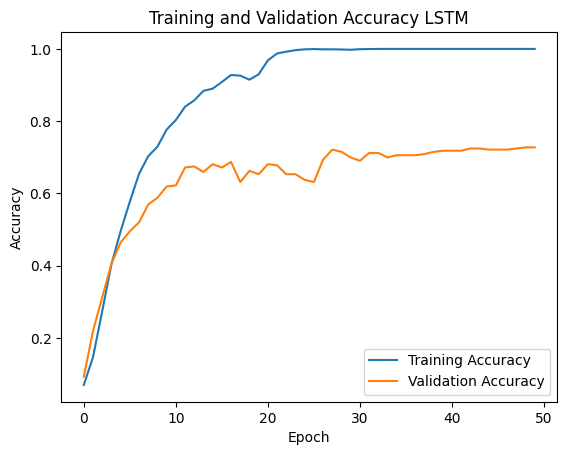

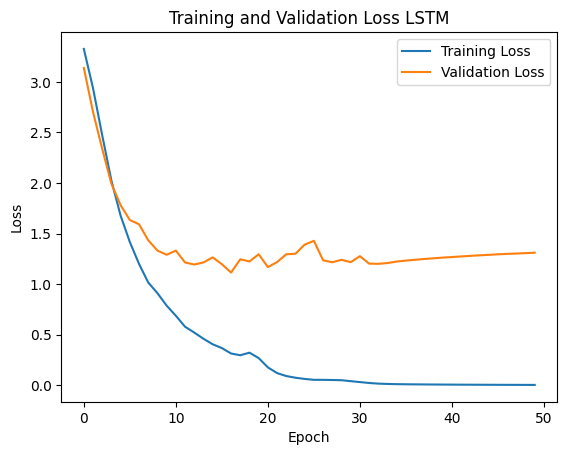

In [ ]:
process50EpochsResults(resultsArr[0],bestArr[0],historiesArr[0],ModelType.LSTM)

In [ ]:
modelType=ModelType.LSTM
batchSize=64
set_seed(42)
train_split_dataset, val_split_dataset = train_test_split(data, stratify=data['label'], test_size=0.1)
train_split_dataset, test_split_dataset = train_test_split(train_split_dataset, stratify=train_split_dataset['label'], test_size=0.1)
# TODO: Use the whole dataset instead
trainDataGenerator = getDatasetGenerator(modelType,train_split_dataset.head(int(len(train_split_dataset)/20)), num_classes, batchSize)
valDataGenerator = getDatasetGenerator(modelType,val_split_dataset.head(int(len(val_split_dataset)/20)), num_classes, batchSize)
testDataGenerator = getDatasetGenerator(modelType,test_split_dataset.head(int(len(test_split_dataset))), num_classes, batchSize)

y_true = []
for index, row in test_split_dataset.iterrows():
    y_true.append(row['label'])


createModelArgs={'modelType':modelType,'optimizer':getOptimizer(optimizer_type=OptimizerType.Adam,learningRate=0.001),'regularizer':{"type":RegularizationType.NoRegularization,"value":0},'loss':'categorical_crossentropy','metrics':['accuracy'],'augmentation':AugmentationTechnique.NoAugmentation,'seed':42,'num_classes':num_classes}
fitModelArgs = {'batch_size':batchSize,'epochs':10,'train_dataset':trainDataGenerator,'val_dataset':valDataGenerator}



Epoch 1/10
41/41 [==============================] - 7s 125ms/step - loss: 3.3303 - accuracy: 0.0668 - val_loss: 3.1419 - val_accuracy: 0.1238
Epoch 2/10
41/41 [==============================] - 5s 114ms/step - loss: 2.9803 - accuracy: 0.1442 - val_loss: 2.7424 - val_accuracy: 0.2043
Epoch 3/10
41/41 [==============================] - 5s 116ms/step - loss: 2.5313 - accuracy: 0.2526 - val_loss: 2.3691 - val_accuracy: 0.3251
Epoch 4/10
41/41 [==============================] - 5s 115ms/step - loss: 2.1386 - accuracy: 0.3602 - val_loss: 2.0283 - val_accuracy: 0.3839
Epoch 5/10
41/41 [==============================] - 5s 113ms/step - loss: 1.8253 - accuracy: 0.4552 - val_loss: 1.8646 - val_accuracy: 0.4087
Epoch 6/10
41/41 [==============================] - 5s 112ms/step - loss: 1.5300 - accuracy: 0.5444 - val_loss: 1.7143 - val_accuracy: 0.4768
Epoch 7/10
41/41 [==============================] - 5s 112ms/step - loss: 1.3034 - accuracy: 0.6250 - val_loss: 1.6320 - val_accuracy: 0.5046
Epoch 

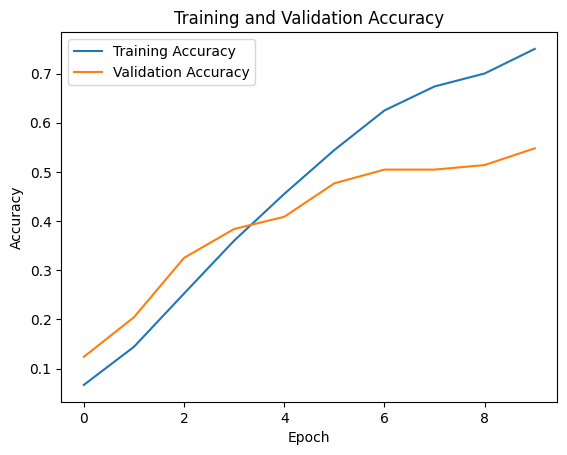

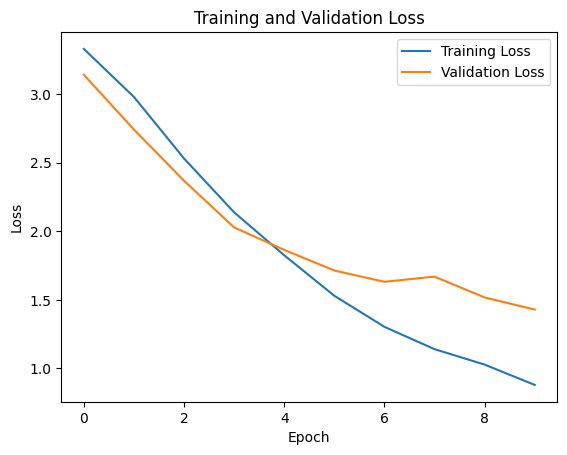

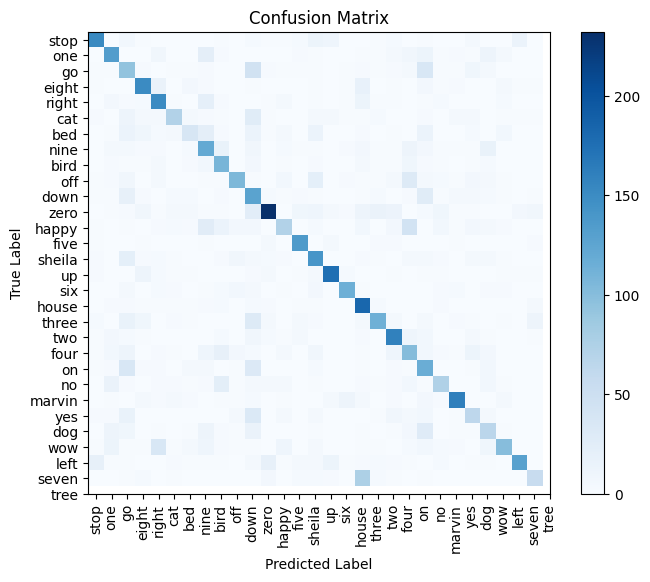

In [ ]:
finalModelTest(createModelArgs,fitModelArgs,testDataGenerator,y_true)

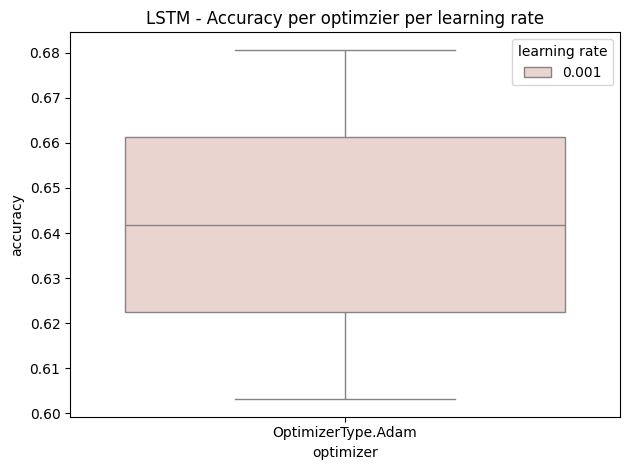

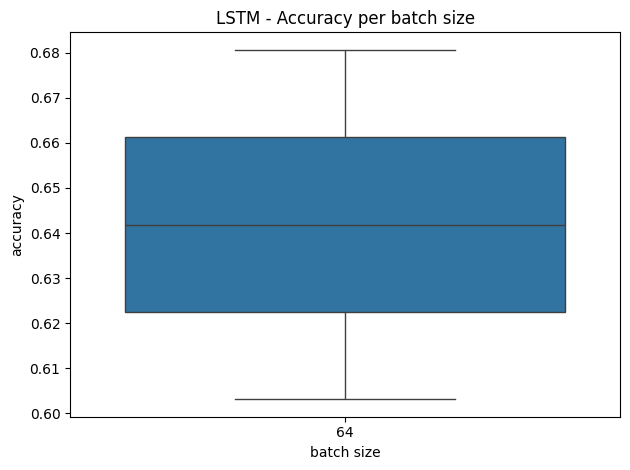

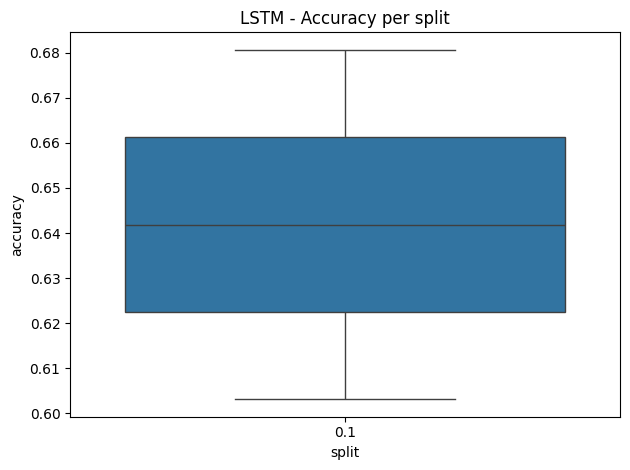

In [ ]:
processParametersResults(results,ModelType.LSTM)